# We test here the ABBA-LSTM algorithm on the Monthly sunspots dataset.

The dataset is available at https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv

This dataset describes a monthly count of the number of observed sunspots for just over 230 years (1749-1983).

The units are a count and there are 2,820 observations. The source of the dataset is credited to Andrews & Herzberg (1985).

## Load the dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def get_data(file_name):
    df = pd.read_csv("data/{}.csv".format(file_name))
    return df

In [3]:
df = get_data("monthly-sunspots")
df["Month"] = pd.to_datetime(df["Month"])

In [4]:
df

,Month,Sunspots
0,1749-01-01,58.0
1,1749-02-01,62.6
2,1749-03-01,70.0
3,1749-04-01,55.7
4,1749-05-01,85.0
...,...,...
2815,1983-08-01,71.8
2816,1983-09-01,50.3
2817,1983-10-01,55.8
2818,1983-11-01,33.3


## Data Analysis

Text(0, 0.5, 'number of sunspots')

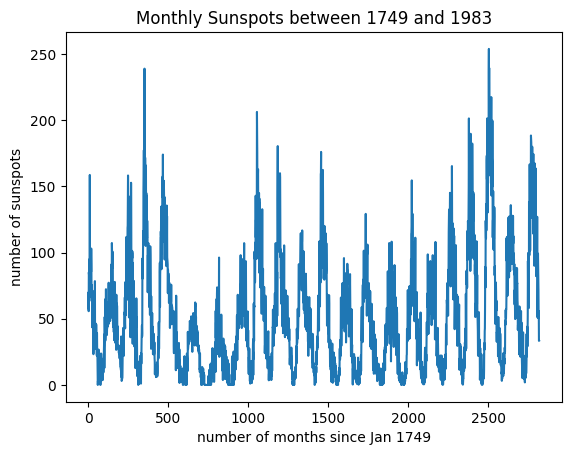

In [5]:
df["Sunspots"].plot()
plt.title("Monthly Sunspots between 1749 and 1983")
plt.xlabel("number of months since Jan 1749")
plt.ylabel("number of sunspots")

Text(0, 0.5, 'number of sunspots')

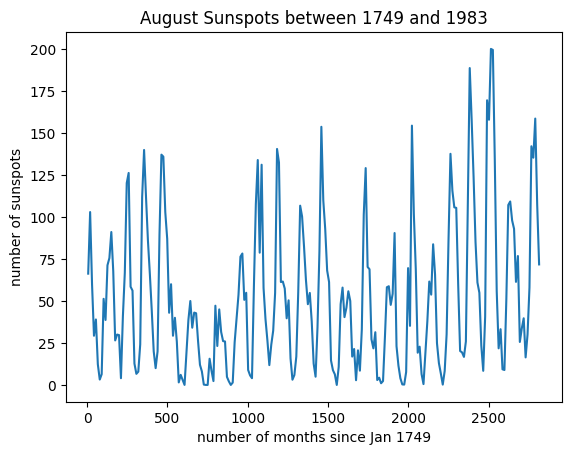

In [6]:
# If we only look the number of sunspots in august of every year:
df[df["Month"].dt.month == 8]["Sunspots"].plot()
plt.title("August Sunspots between 1749 and 1983")
plt.xlabel("number of months since Jan 1749")
plt.ylabel("number of sunspots")

Text(0, 0.5, 'number of sunspots')

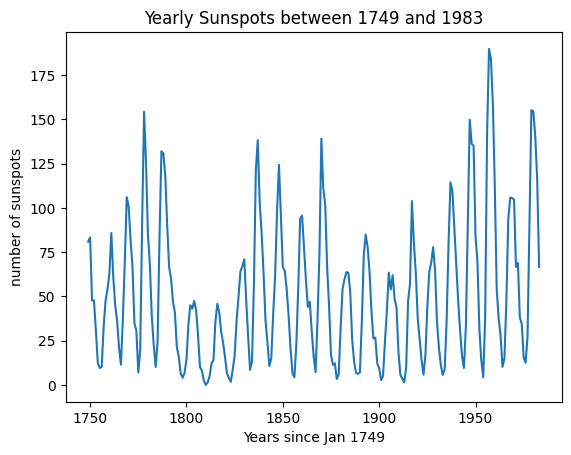

In [7]:
df.groupby(df["Month"].dt.year)["Sunspots"].mean().plot()
plt.title("Yearly Sunspots between 1749 and 1983")
plt.xlabel("Years since Jan 1749")
plt.ylabel("number of sunspots")

In [8]:
df["Relative_Sunspots"] = df["Sunspots"] - df["Month"].dt.year.map(
    df.groupby(df["Month"].dt.year)["Sunspots"].mean()
)

Text(0, 0.5, 'number of sunspots')

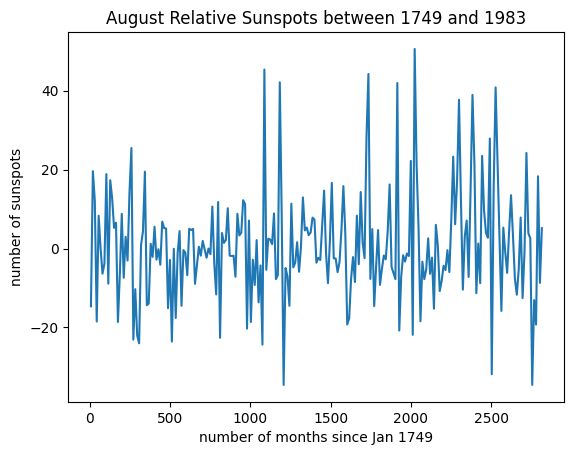

In [9]:
df[df["Month"].dt.month == 8]["Relative_Sunspots"].plot()
plt.title("August Relative Sunspots between 1749 and 1983")
plt.xlabel("number of months since Jan 1749")
plt.ylabel("number of sunspots")

We can see from the plots above that there is not only a high variance between the different months of the year but also a high variance between the mean number of sunspots from one year to another. If we look at the relative number of sunspots, we can see that August is not the month with the most sunspots overall. We can still see though some sort of periodicity in the data.

## Preprocessing

Since some months are unusually sunny sometimes, we decide to smooth the data by taking the mean over the previous month and the next month

Text(0, 0.5, 'number of sunspots')

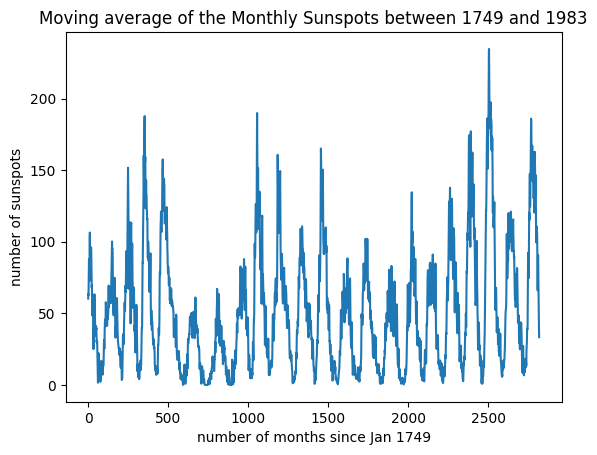

In [10]:
df["ra_Sunspots"] = df["Sunspots"].rolling(3, center=True, min_periods=1).mean()
df["ra_Sunspots"].plot()
plt.title("Moving average of the Monthly Sunspots between 1749 and 1983")
plt.xlabel("number of months since Jan 1749")
plt.ylabel("number of sunspots")

In [11]:
# We normalize the data to better analize it
df["norm_Sunspots"] = (df["ra_Sunspots"] - df["ra_Sunspots"].mean()) / df[
    "ra_Sunspots"
].std()

Text(0, 0.5, 'number of sunspots')

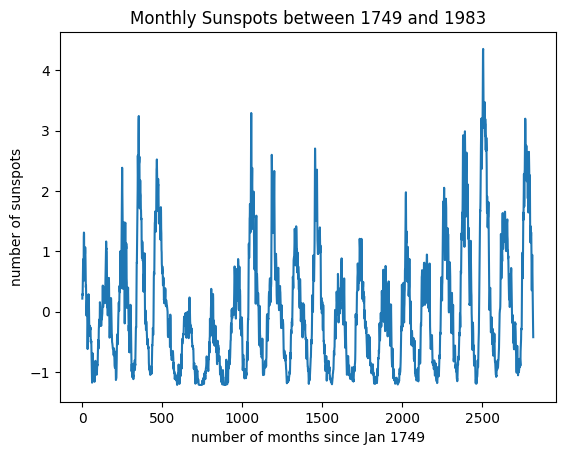

In [12]:
df["norm_Sunspots"].plot()
plt.title("Monthly Sunspots between 1749 and 1983")
plt.xlabel("number of months since Jan 1749")
plt.ylabel("number of sunspots")

In [13]:
from scipy.signal import spectrogram
from numpy.fft import rfft, rfftfreq

N = len(df["norm_Sunspots"])
FS = 1

f, t, Sxx = spectrogram(df["norm_Sunspots"], fs=FS, nperseg=100)

Text(0.5, 1.0, 'Spectrogram of Sunspots')

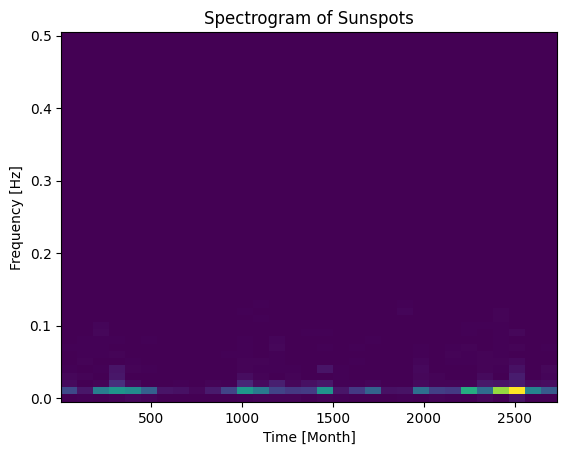

In [14]:
plt.pcolormesh(t, f, Sxx)
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [Month]")
plt.title("Spectrogram of Sunspots")

Text(0.5, 1.0, 'Periodogram')

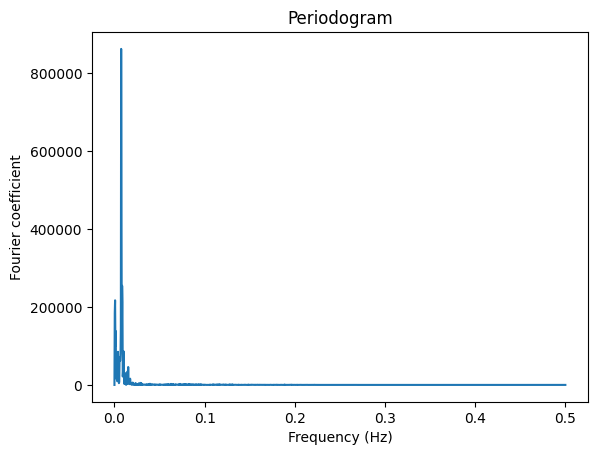

In [15]:
fourier = abs(rfft(df["norm_Sunspots"])) ** 2
freqs = rfftfreq(n=N, d=1.0 / FS)
plt.plot(freqs, fourier)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Fourier coefficient")
plt.title("Periodogram")

In [16]:
print(f"The frequency that appears the most:{freqs[np.argmax(fourier)]: .3f} Hz")

The frequency that appears the most: 0.007 Hz


As we can see on the plot, the signal is periodic  as expected but with a main period of 142 months. This means that the cycle is renewed every 11 to 12 years instead of each year. This coincides from physical observations of the solar cycle.

As seen before, we should not expect high frequencies since most months are not particularly more sunny than others. We can see it better with the autocorrelation plot showed below.

Text(0.5, 0, 'Lag (Months)')

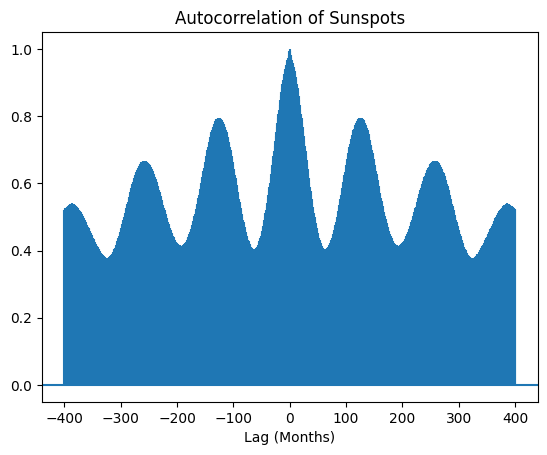

In [17]:
plt.acorr(df["ra_Sunspots"], usevlines=True, normed=True, maxlags=400)
plt.title("Autocorrelation of Sunspots")
plt.xlabel("Lag (Months)")

## Symbolic Representation

In [18]:
time_series = df["norm_Sunspots"].values.astype(np.float32)

In [39]:
from src.abba import ABBA

abba = ABBA(increment_threshold=0.005, max_length=50, max_cluster_size=40)

nb of linear pieces:  2307


Text(0.5, 1.0, 'Reconstruction after compression')

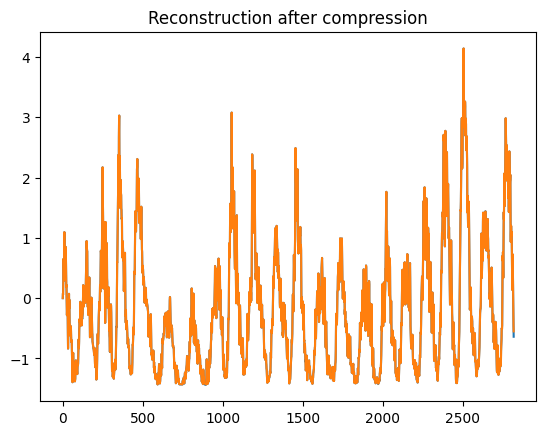

In [40]:
standardized_time_series = abba.standardize(time_series)
linear_pieces = abba.get_linear_pieces(standardized_time_series)
print("nb of linear pieces: ", len(linear_pieces))
plt.plot(standardized_time_series)
plt.plot(abba.unfold_linear_pieces(linear_pieces))
plt.title("Reconstruction after compression")

string_representation='ecjemfafxec}dreaebflfdfhbgdechlhgegvehghbhdeodadqdacqhfaegjdafdcabccabairibcbanocnid|baejdeadbgkohagadfewijjdhfdegbehddeqcgkgcrjfcacplfcghkhjaknb{higakakaecfhbbab\x85adeaqyjaglcfue\x80dconjrnabekebcvkahpjekgmsmjlpahptd~gadct}pj\x82xc}fjmaebtapjbgacdehhbfefahijegjeabzlfaedbfcncbdbugiiefeajejeim~ckkekmxlfh\x82kd}ietlrkhihcfipfbjeofdbhlgeahkmdl{cfjhcbgcabaqanifcdaahodawauncbanrcdegabdg~eisvcjbhajeisjdgfbzfekjbclbhkbeiafahkjealblahabeobfcdeohcbjwgihie\x85fhaegiafedefhbjmahlabdydciieabafefdbdibddiaiyeibcuniedabobidcnoege\x7fjegbwdcirdoawbbcegfhadjbngcbidqfegkgdcfahabidacaebabaaiw\x7feccbcoyi|oiwbodia\x87dwdibueiadacagaeuncycaeycrcgdefkdkhcbkakdkhhqdrqgsblpvahfaeockeafbdfiefbckedfigachidcobfdeobiaigcafarcbaco\x88vefcacfcgjcqggiajecqdcdedecjdfimfdbnyaeyrdjkabpcfabajsgcaeflbdadjsaftfamkglhedbtbgiobejabhbhfngbcfacbdaeuceobnadgvfabsgecgskmfadgsdjhahge\x82mstpt\x80tlhkgfefspfpqcdgjc{fj\x86dttbgaqobjbaf\x81gkjbhfcfdacfncbijechlbagioandacecbceibedkgkdbhbcnkcedkdcfamedldbgfkcd

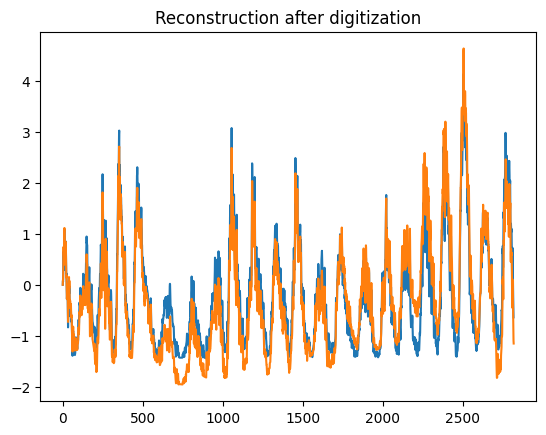

In [41]:
labels, _, _ = abba.learn_transform(standardized_time_series)
string_representation = abba.apply_transform_to_str(standardized_time_series)
print(f"{string_representation=}")

reconstructed_linear = abba.apply_inverse_transform_from_str(string_representation)

plt.plot(standardized_time_series)
plt.plot(reconstructed_linear)
plt.title("Reconstruction after digitization")
plt.show()

## ABBA Training

In [47]:
from src.forecasting.dataset import get_datasets_and_loaders

batch_size = 32


test_split_ratio = 0.2
sequence_length = 20


abba = ABBA(increment_threshold=0.005, max_length=50, max_cluster_size=40)

standardized_time_series = abba.standardize(time_series)

raw_train, raw_test, train_loader, test_loader = get_datasets_and_loaders(
    standardized_time_series,
    batch_size=batch_size,
    test_split_ratio=test_split_ratio,
    sequence_length=sequence_length,
    num_workers=0,
    abba=abba,
)

Average time series length per symbol: 1.235487404162103
(500,)


In [49]:
from src.forecasting.models import ABBAForecastingLSTM
from src.forecasting.training import train_loop, accuracy, mse, test_loop
import torch

model = ABBAForecastingLSTM(
    language_size=len(abba.language),
    hidden_size=64,
    num_layers=2,
)


loss_function = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100

for epoch in range(num_epochs):
    train_loss, train_accuracy = train_loop(
        model,
        train_loader,
        optimizer,
        loss_function,
        accuracy,
        device=torch.device("cpu"),
    )

    test_loss, test_accuracy = test_loop(
        model,
        test_loader,
        loss_function,
        accuracy,
        device=torch.device("cpu"),
    )

    print(
        f"Epoch {epoch} - Train Loss: {train_loss:.3f} - Train Accuracy: {train_accuracy:.3f} - Test Loss: {test_loss:.3f} - Test Accuracy: {test_accuracy:.3f}"
    )

Epoch 0 - Train Loss: 0.003 - Train Accuracy: 0.106 - Test Loss: 0.098 - Test Accuracy: 0.090
Epoch 1 - Train Loss: 0.003 - Train Accuracy: 0.111 - Test Loss: 0.098 - Test Accuracy: 0.081
Epoch 2 - Train Loss: 0.004 - Train Accuracy: 0.117 - Test Loss: 0.097 - Test Accuracy: 0.081
Epoch 3 - Train Loss: 0.003 - Train Accuracy: 0.117 - Test Loss: 0.096 - Test Accuracy: 0.069
Epoch 4 - Train Loss: 0.003 - Train Accuracy: 0.111 - Test Loss: 0.095 - Test Accuracy: 0.092
Epoch 5 - Train Loss: 0.003 - Train Accuracy: 0.122 - Test Loss: 0.095 - Test Accuracy: 0.075
Epoch 6 - Train Loss: 0.003 - Train Accuracy: 0.147 - Test Loss: 0.094 - Test Accuracy: 0.110
Epoch 7 - Train Loss: 0.003 - Train Accuracy: 0.154 - Test Loss: 0.094 - Test Accuracy: 0.090
Epoch 8 - Train Loss: 0.003 - Train Accuracy: 0.158 - Test Loss: 0.094 - Test Accuracy: 0.100
Epoch 9 - Train Loss: 0.003 - Train Accuracy: 0.170 - Test Loss: 0.094 - Test Accuracy: 0.104
Epoch 10 - Train Loss: 0.003 - Train Accuracy: 0.183 - Test 

# Comparison with classical LSTM

In [50]:
import torch

from src.forecasting.dataset import get_datasets_and_loaders

batch_size = 64


test_split_ratio = 0.2
sequence_length = 200

standardized_time_series = abba.standardize(time_series)

raw_train, raw_test, train_loader, test_loader = get_datasets_and_loaders(
    standardized_time_series,
    batch_size=batch_size,
    test_split_ratio=test_split_ratio,
    sequence_length=sequence_length,
    num_workers=0,
    abba=None,
)

(764,)


In [51]:
from src.forecasting.models import RegressionForecastingLSTM
from src.forecasting.training import train_loop, accuracy, mse, test_loop
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = RegressionForecastingLSTM(
    hidden_size=64,
    num_layers=2,
).to(device)

loss_function = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50

for epoch in range(num_epochs):
    train_loss, train_mse = train_loop(
        model,
        train_loader,
        optimizer,
        loss_function,
        mse,
        device=device,
    )

    test_loss, test_mse = test_loop(
        model,
        test_loader,
        loss_function,
        mse,
        device=device,
    )

    print(
        f"Epoch {epoch} - Train Loss: {train_loss*1000:.3f} - Train MSE: {train_mse*1000:.3f} - Test Loss: {test_loss*1000:.3f} - Test MSE: {test_mse*1000:.3f}"
    )

Epoch 0 - Train Loss: 0.079 - Train MSE: 468.151 - Test Loss: 8.519 - Test MSE: 529.073
Epoch 1 - Train Loss: 0.110 - Train MSE: 117.831 - Test Loss: 3.677 - Test MSE: 229.409
Epoch 2 - Train Loss: 0.027 - Train MSE: 86.752 - Test Loss: 3.040 - Test MSE: 189.364
Epoch 3 - Train Loss: 0.083 - Train MSE: 77.909 - Test Loss: 2.419 - Test MSE: 150.791
Epoch 4 - Train Loss: 0.033 - Train MSE: 71.554 - Test Loss: 2.721 - Test MSE: 169.049
Epoch 5 - Train Loss: 0.057 - Train MSE: 66.541 - Test Loss: 1.900 - Test MSE: 117.923
Epoch 6 - Train Loss: 0.083 - Train MSE: 58.209 - Test Loss: 1.582 - Test MSE: 98.545
Epoch 7 - Train Loss: 0.051 - Train MSE: 50.213 - Test Loss: 1.552 - Test MSE: 96.544
Epoch 8 - Train Loss: 0.084 - Train MSE: 41.483 - Test Loss: 1.048 - Test MSE: 65.177
Epoch 9 - Train Loss: 0.068 - Train MSE: 32.502 - Test Loss: 0.887 - Test MSE: 55.051
Epoch 10 - Train Loss: 0.092 - Train MSE: 24.238 - Test Loss: 0.794 - Test MSE: 49.440
Epoch 11 - Train Loss: 0.017 - Train MSE: 25.

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.

Autoregressive prediction DTW:  0.3189498635912182
Non Autoregressive prediction DTW:  0.06668859239542156


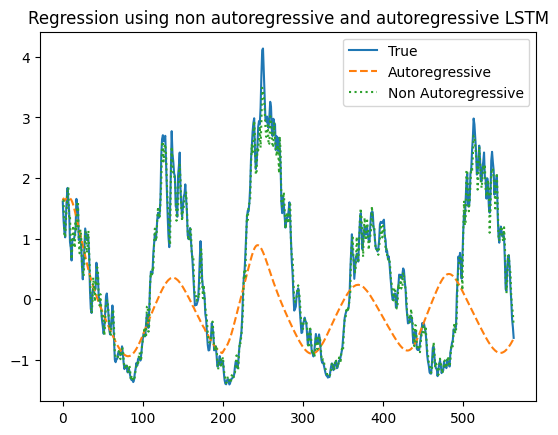

In [52]:
from torch.utils.data import Dataset
from src.forecasting.training import forecast
from dtw import dtw


test_data = np.array([test_loader.dataset[i][1] for i in range(len(test_loader.dataset))])  # type: ignore

model.to(torch.device("cpu"))

autoregressive_predictions = forecast(
    model, test_loader.dataset, auto_regressive=True, abba=None
)
non_autoregressive_predictions = forecast(
    model, test_loader.dataset, auto_regressive=False, abba=None
)

print(
    "Autoregressive prediction DTW: ",
    dtw(autoregressive_predictions, raw_test).normalizedDistance,
)
print(
    "Non Autoregressive prediction DTW: ",
    dtw(non_autoregressive_predictions, raw_test).normalizedDistance,
)


plt.plot(raw_test, label="True")
plt.plot(autoregressive_predictions, label="Autoregressive", linestyle="--")
plt.plot(non_autoregressive_predictions, label="Non Autoregressive", linestyle=":")
plt.title("Regression using non autoregressive and autoregressive LSTM")
plt.legend()
plt.show()